In [104]:
import swissgrid
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
ts = swissgrid.grid_data.iloc[:,0]
SAMPS_DAY = 24*4

In [33]:
weather = pd.read_csv('data/weather_data_filtered.csv')
weather['timestamp'] = pd.to_datetime(weather['utc_timestamp'])
weather = weather[['timestamp', 'CH_temperature']].set_index('timestamp').sort_index()
weather = weather.tz_localize(None)

### autoregressive part

The consumption $L_{hd}$ today at day $d$ and hour $h$ depends on $L_{h-1d}$, $L_{hd-1}$, $L_{hd-7}$

In [75]:
7*52

364

In [19]:
np.vstack([week_lag_idx, day_lag_idx, hour_lag_idx]).shape

(3, 352895)

In [ ]:
def day_lags_reg(day_lag_ts):
    I = np.eye(7)
    np.array([I[i] for i in day_lag_ts.dayofweek])

In [110]:
def build_ts_regressor(ts, fourier_order=4):
    #interact annual pattern like (6)
    ts.index[SAMPS_DAY*7:ts.size]
    week_lag_idx = np.arange(ts.size-SAMPS_DAY*7)
    t = ((
        ts.index[SAMPS_DAY*7:ts.size] - pd.datetime(year=ts.index[0].year, month=1, day=1)
    ).total_seconds()//(60*24*60/SAMPS_DAY)).astype(np.intp)
    samps_year = SAMPS_DAY*7*52
    sins =  np.array([np.sin(2*q*np.pi*(t/samps_year)) for q in range(1, fourier_order+1)]).T
    cosins =np.array([np.cos(2*q*np.pi*(t/samps_year)) for q in range(1, fourier_order+1)]).T
    week_lagged_reg = ts.values[week_lag_idx,None]*np.hstack([np.ones((week_lag_idx.size,1)), sins, cosins])
    
    week_day = ts.index[SAMPS_DAY*7:ts.size].dayofweek
    I = np.eye(7)
    week_day_indicators = np.array([I[i] for i in week_day])
    day_lag_idx = np.arange(SAMPS_DAY*6, ts.size-SAMPS_DAY)
    day_lagged_reg = ts.values[day_lag_idx,None]*week_day_indicators
    
    hour_lag_idx = np.arange(SAMPS_DAY*7 - 1, ts.size-1)
    hour_lagged_reg = ts.values[hour_lag_idx][:,None]
    
    return np.hstack([week_lagged_reg, day_lagged_reg, hour_lagged_reg])
    # need constant regressor
    # need temperature regressors
    # need special days

In [101]:
reg  =build_ts_regressor(ts)

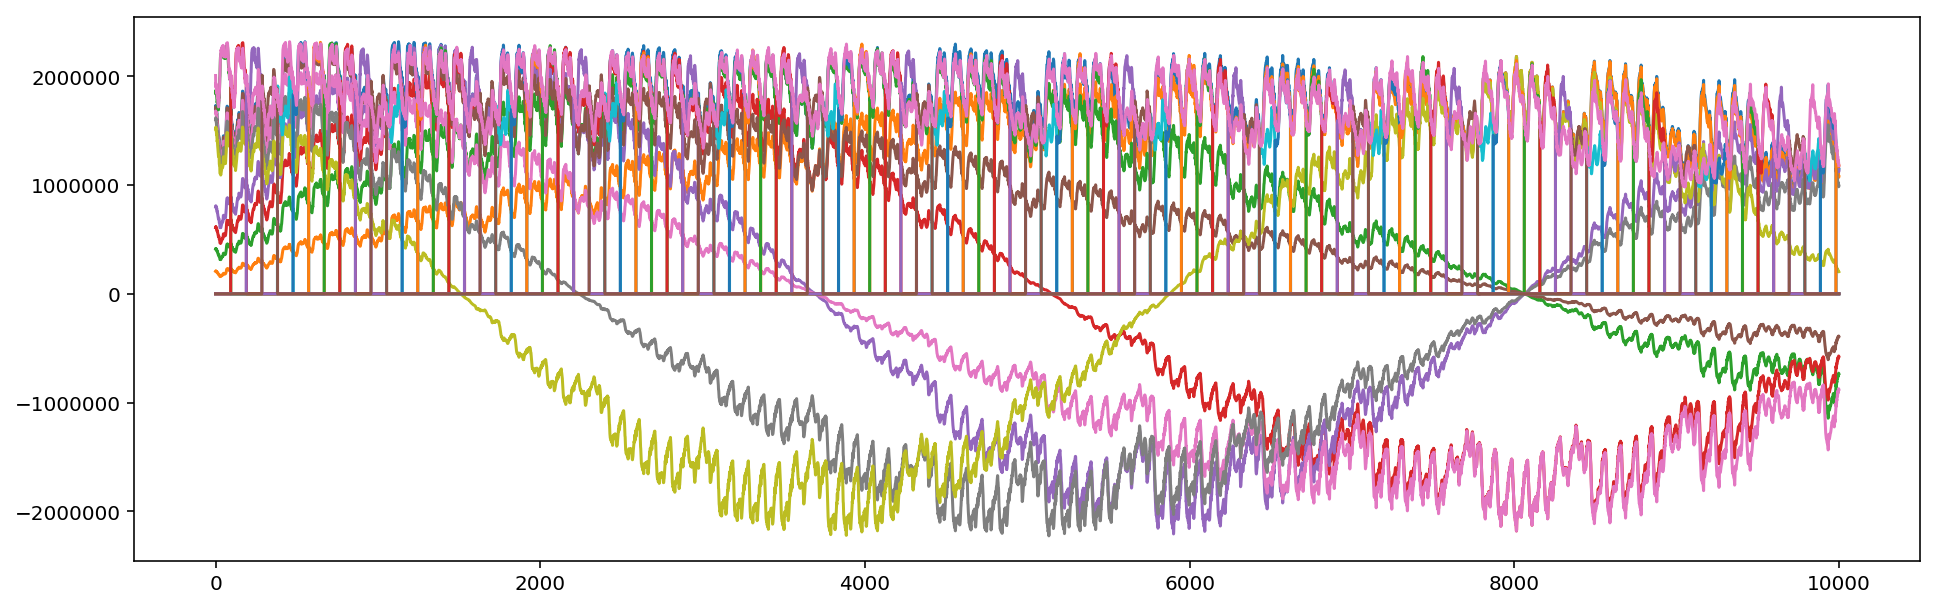

In [109]:
for i in range(reg.shape[1]):
    plt.plot(reg[:10000,i])

In [57]:
ts.index[SAMPS_DAY*7:ts.size]


DatetimeIndex(['2009-01-08 00:30:00', '2009-01-08 00:45:00',
               '2009-01-08 01:00:00', '2009-01-08 01:15:00',
               '2009-01-08 01:30:00', '2009-01-08 01:45:00',
               '2009-01-08 02:00:00', '2009-01-08 02:15:00',
               '2009-01-08 02:30:00', '2009-01-08 02:45:00',
               ...
               '2019-01-31 21:45:00', '2019-01-31 22:00:00',
               '2019-01-31 22:15:00', '2019-01-31 22:30:00',
               '2019-01-31 22:45:00', '2019-01-31 23:00:00',
               '2019-01-31 23:15:00', '2019-01-31 23:30:00',
               '2019-01-31 23:45:00', '2019-02-01 00:00:00'],
              dtype='datetime64[ns]', name='time', length=352895, freq='15T')

In [28]:
reg = build_ts_regressor(ts)
y = ts.iloc[SAMPS_DAY*7:]